## 패키지 설치

    $ pip install imageio
$ pip install Pillow

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [3]:
print('max pixel : ',train_x.max())
print('max pixel : ',train_x.min())

max pixel :  255
max pixel :  0


In [4]:
train_x = (train_x - 127.5) / 127.5  # 이미지를  [-1, 1]로 바꿈

print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

In [6]:
# gray scale이기 때문에 각 이미지의 채널은 1로 설정
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

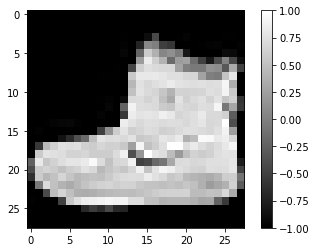

In [7]:
# 이미지 확인
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

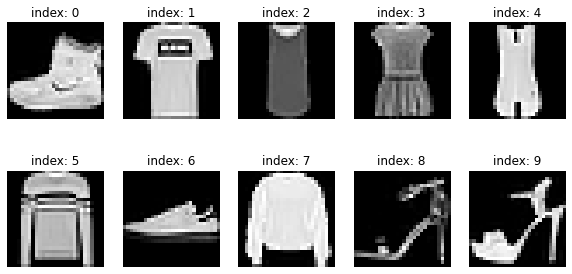

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

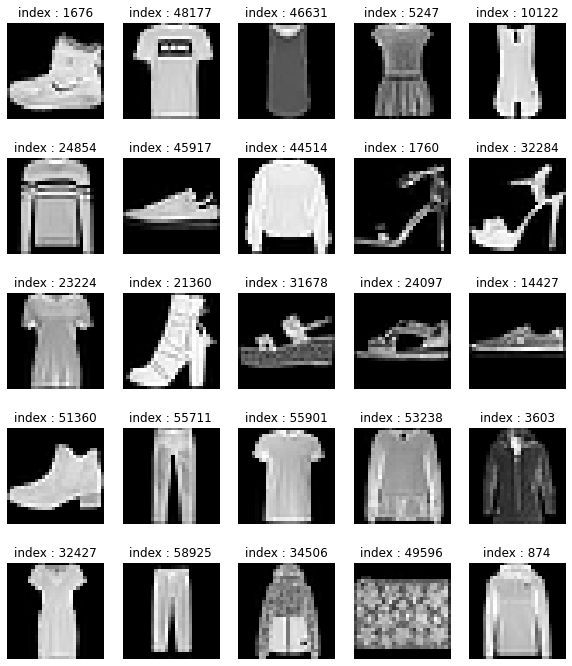

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random = np.random.randint(1, 60000)
    plt.imshow(train_x[i].reshape(28,28), cmap='gray')
    plt.title(f'index : {random}')
    plt.axis('off')
plt.show()

## Dataset 준비

In [10]:
BUFFER_SIZE = 60000  # 전체 데이터를 섞기 위한 설정
# shuffle 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것임
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## GAN 모델
### 생성자 구현

- Tensorflow 2.0 Tutorial의 DCGAN 구현
    - https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko
- 텐서플로 추상화와 간소화, keras
    - https://excelsior-cjh.tistory.com/159

In [17]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((7,7,256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2,2), padding='same', use_bias=False,
                                     activation='tanh'))
    
    return model

- Conv2DTranspose : Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
    - 3개로 (7,7,256) -> (14, 14, 64) -> (28, 28, 1)
    - https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11
- BatchNormalization : 신경망의 가중치가 폭발하지 않게 정규화
    - https://m.blog.naver.com/laonple/220808903260
- 활성화함수
    - 중간층은 LeakyReLU 사용
    - 마지막은 tanh : -1 ~ 1로 픽셀값을 정규화하기 위해
    - https://newly0513.tistory.com/20

In [19]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)        

In [20]:
noise = tf.random.normal([1, 100])
# 가우시안분포에서 랜덤 벡터를 뽑아냄

In [21]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

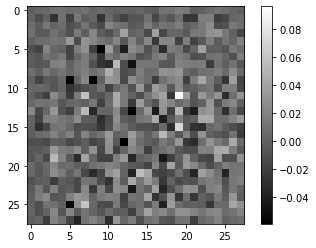

In [22]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

### 판별자 구현

In [26]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding = 'same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flattern Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense layer
    model.add(layers.Dense(1))
    
    return model

- (28, 28, 1) → (14, 14, 64) → (7, 7, 128) 로 사이즈가 줄어듦


In [27]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [28]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00439244]], dtype=float32)>

## 손실함수, 최적화함수

### 손실함수

- 생성자
    - 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
- 판별자
    - Real Image 판별값, 즉 D(real_image)는 1에
    - Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- 그런데 tf.keras.losses의 BinaryCrossEntropy 클래스
    - 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다
- 따라서 from_logits를 True로 설정해 주어야
    - BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화 한 후 알맞게 계산할 수 있습니다.

- tf.ones_like()와 tf.zeros_like()
    - 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용

In [30]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [31]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [32]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [33]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

1. tf.math.greater_equal(real_output, tf.constant([0.5])
    - real_output의 각 원소가 0.5 이상인지 True, False로 판별
    > tf.Tensor([False, False, True, True])
2. tf.cast( (1), tf.float32)
    - (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
    > tf.Tensor([0.0, 0.0, 1.0, 1.0])
3. tf.reduce_mean( (2))
    - (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
    > 0.5


### 최적화함수

- https://sacko.tistory.com/42

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [35]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정

- decorator를 이용해 훈련 함수 구현
    - https://bluese05.tistory.com/30

In [36]:
import numpy as np
import tensorflow as tf

def f(x, y):
    print(type(x))
    print(type(y))
    return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [38]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
    print(type(x))
    print(type(y))
    return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [39]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

1. 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
2. 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
3. tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동미분으로 계산하기 위해 with 구문 열기
4. (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
5. discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
6. loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
7. accuracy 계산 : fake_output, real_output으로 discriminator가
8. gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
9. 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
10. 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴


In [46]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('/home/aiffel0049/aiffel/Exploration/16.gan/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [47]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/home/aiffel0049/aiffel/Exploration/16.gan/fashion/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [48]:
checkpoint_dir = '/home/aiffel0049/aiffel/Exploration/16.gan/fashion/training_checkpoints/'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## training

In [49]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [50]:
save_every = 5
EPOCHS = 50

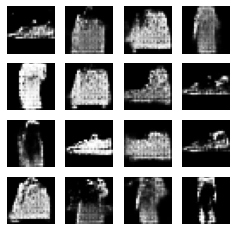

Time for training : 576 sec


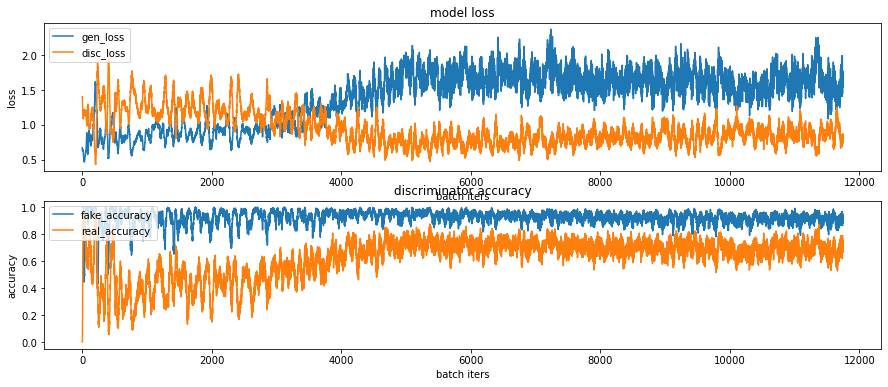

CPU times: user 3min 23s, sys: 10.3 s, total: 3min 33s
Wall time: 9min 37s


In [51]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [56]:
anim_file = '/home/aiffel0049/aiffel/Exploration/16.gan/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/home/aiffel0049/aiffel/Exploration/16.gan/fashion/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/Exploration/16.gan/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel0049 aiffel0049 1316029 10월  6 19:05 /home/aiffel0049/aiffel/Exploration/16.gan/fashion/fashion_mnist_dcgan.gif
